# Задание 1 (6 баллов)

В данном задании мы будем работать со [списком 250 лучших фильмов IMDb](https://www.imdb.com/chart/top/?ref_=nv_mp_mv250)

1. Выведите топ-4 *фильма* **по количеству оценок пользователей** и **количество этих оценок** (1 балл)
2. Выведите топ-4 лучших *года* (**по среднему рейтингу фильмов в этом году**) и **средний рейтинг** (1 балл)
3. Постройте отсортированный **barplot**, где показано **количество фильмов** из списка **для каждого режисёра** (только для режиссёров с более чем 2 фильмами в списке) (1 балл)
4. Выведите топ-4 самых популярных *режиссёра* (**по общему числу людей оценивших их фильмы**) (2 балла)
5. Сохраните данные по всем 250 фильмам в виде таблицы с колонками (name, rank, year, rating, n_reviews, director) в любом формате (2 балла)

Использовать можно что-угодно, но полученные данные должны быть +- актуальными на момент сдачи задания

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
response = requests.get('https://www.imdb.com/chart/top/?ref_=nv_mp_mv250', 
                        headers = {'Accept-Language': 'en-EN,en;q=0.9'})

1. Топ-4 *фильма* **по количеству оценок пользователей** и **количество этих оценок**

In [3]:
soup = BeautifulSoup(response.content, 'lxml')
rating_string = soup.find_all('td', class_="ratingColumn imdbRating")
names_of_film = soup.find_all('td', class_="titleColumn")

In [4]:
for i in range(4):
    print(names_of_film[i].find('a').text, end=' - ')
    print(rating_string[i].find('strong').attrs['title'])

The Shawshank Redemption - 9.2 based on 2,720,798 user ratings
The Godfather - 9.2 based on 1,890,749 user ratings
The Dark Knight - 9.0 based on 2,693,621 user ratings
The Godfather Part II - 9.0 based on 1,290,004 user ratings


2. Топ-4 лучших *года* (**по среднему рейтингу фильмов в этом году**) и **средний рейтинг**

In [5]:
years_rates = dict()

for i in range(len(names_of_film)):
    year = names_of_film[i].find('span', class_="secondaryInfo").text.strip('()')
    rating = rating_string[i].find('strong').text
    
    years_rates[year] = years_rates.get(year, np.array([0, 0])) + np.array([float(rating), 1])

for year, stats in years_rates.items():
    years_rates.update({year: round(stats[0]/stats[1], 2)})

In [6]:
pd.DataFrame.from_dict(years_rates, orient='index', columns = ['Average Rating']).sort_values(by='Average Rating', ascending=False).head(4)

,Average Rating
1972,9.20
1994,8.76
1974,8.55
1991,8.55


3. Отсортированный **barplot**, где показано **количество фильмов** из списка **для каждого режисёра** (только для режиссёров с более чем 2 фильмами в списке)

**Решил побаловаться с векторизацией и итераторами** 

In [7]:
directors = dict()

dirs = soup.find_all('a', title=lambda x: 'dir' in x if x else False)
directors = list(map(lambda x: re.search(string=x.attrs['title'], 
                    pattern=r'([\w ]+) \(dir\.\)').group(1), dirs))

num_films = np.array(np.unique(directors, return_counts=True))
num_films_filt = num_films[:,num_films[1,:].astype('int64') > 2]

In [8]:
sig_dirs_df = pd.DataFrame(num_films_filt.T,
                           columns=["Director","Number of films"]).sort_values(by="Number of films", ascending=False)
sig_dirs_df["Number of films"] = sig_dirs_df["Number of films"].astype('int64')

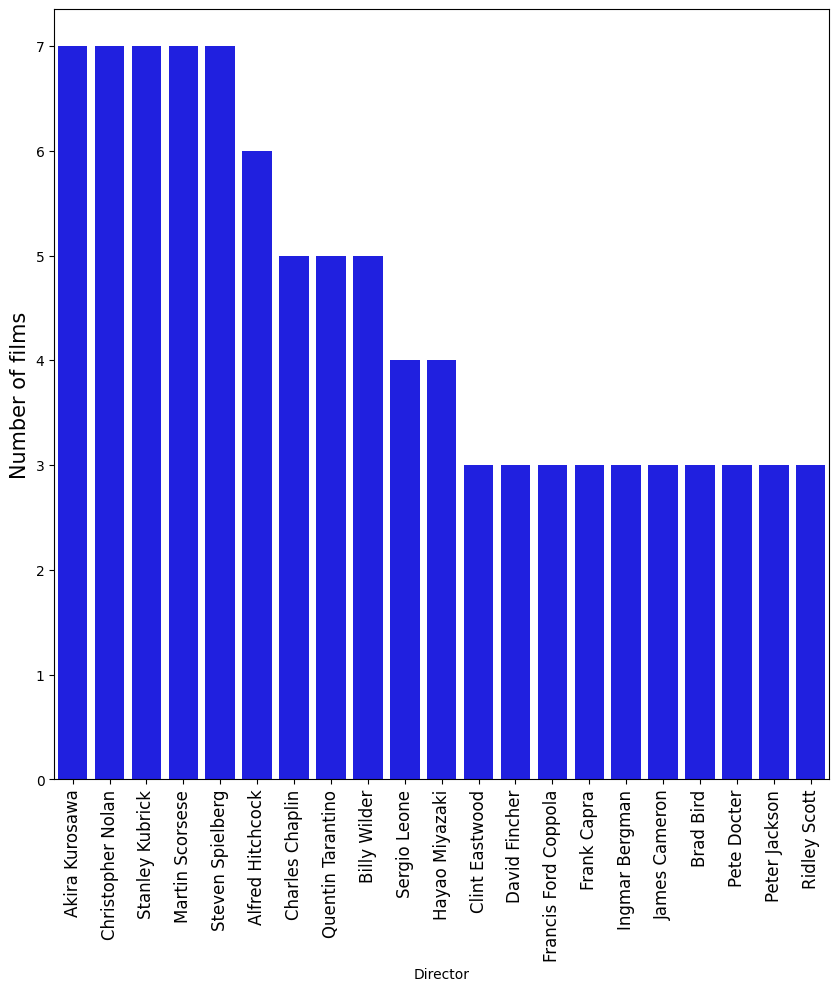

In [9]:
plt.rcParams["figure.figsize"] = (10,10)
plt.xticks(rotation=90, fontsize=12)
plt.ylabel('Number of films', fontsize=15)
sns.barplot(x=sig_dirs_df['Director'] ,y=sig_dirs_df['Number of films'], color='blue');

4. Топ-4 самых популярных *режиссёра* (**по общему числу людей оценивших их фильмы**)

In [10]:
ratings = soup.find_all('strong', title=lambda x: 'based on' in x if x else False)

people_num_str = map(lambda x: re.search(string=x.attrs['title'], 
                        pattern=r' ([\d,]+) ').group(1), ratings)

people_num = list(map(lambda x: int(x.replace(',','')), people_num_str))


In [11]:
pd.DataFrame({"Director":directors, "People rated":people_num}).groupby('Director').sum().sort_values(by="People rated", ascending=False).head(4)

,People rated
Director,
Christopher Nolan,12792345
Quentin Tarantino,7315572
Steven Spielberg,7162379
Martin Scorsese,7057069


5. Данные по всем 250 фильмам в виде таблицы с колонками

In [12]:
ratings = list(map(lambda x: float(x.text) ,ratings))

In [13]:
years = list(map(lambda x: int(x.find('span', class_='secondaryInfo').text.strip('()')), names_of_film))

In [14]:
names_of_films = list(map(lambda x: x.find('a').text, names_of_film))

In [15]:
df = pd.DataFrame({
    'Name':names_of_films,
    'Year':years,
    'Rating':ratings,
    'Number of viewers':people_num,
    'Director':directors
})

df.index += 1
df.index.name = "Rank"

df

,Name,Year,Rating,Number of viewers,Director
Rank,,,,,
1,The Shawshank Redemption,1994,9.2,2720798,Frank Darabont
2,The Godfather,1972,9.2,1890749,Francis Ford Coppola
3,The Dark Knight,2008,9.0,2693621,Christopher Nolan
4,The Godfather Part II,1974,9.0,1290004,Francis Ford Coppola
5,12 Angry Men,1957,9.0,804270,Sidney Lumet
...,...,...,...,...,...
246,The Iron Giant,1999,8.0,205888,Brad Bird
247,The Help,2011,8.0,468092,Tate Taylor
248,Dersu Uzala,1975,8.0,31388,Akira Kurosawa


In [16]:
df.to_csv('../data/Top_250_IMDb.csv', index=True)

# Задание 2 (10 баллов)

Напишите декоратор `telegram_logger`, который будет логировать запуски декорируемых функций и отправлять сообщения в телеграм.


Вся информация про API телеграм ботов есть в официальной документации, начать изучение можно с [этой страницы](https://core.telegram.org/bots#how-do-bots-work) (разделы "How Do Bots Work?" и "How Do I Create a Bot?"), далее идите в [API reference](https://core.telegram.org/bots/api)

**Основной функционал:**
1. Декоратор должен принимать **один обязательный аргумент** &mdash; ваш **CHAT_ID** в телеграме. Как узнать свой **CHAT_ID** можно найти в интернете
2. В сообщении об успешно завершённой функции должны быть указаны её **имя** и **время выполнения**
3. В сообщении о функции, завершившейся с исключением, должно быть указано **имя функции**, **тип** и **текст ошибки**
4. Ключевые элементы сообщения должны быть выделены **как код** (см. скриншот), форматирование остальных элементов по вашему желанию
5. Время выполнения менее 1 дня отображается как `HH:MM:SS.μμμμμμ`, время выполнения более 1 дня как `DDD days, HH:MM:SS`. Писать форматирование самим не нужно, всё уже где-то сделано за вас

**Дополнительный функционал:**
1. К сообщению также должен быть прикреплён **файл**, содержащий всё, что декорируемая функция записывала в `stdout` и `stderr` во время выполнения. Имя файла это имя декорируемой функции с расширением `.log` (**+3 дополнительных балла**)
2. Реализовать предыдущий пункт, не создавая файлов на диске (**+2 дополнительных балла**)
3. Если функция ничего не печатает в `stdout` и `stderr` &mdash; отправлять файл не нужно

**Важные примечания:**
1. Ни в коем случае не храните свой API токен в коде и не загружайте его ни в каком виде свой в репозиторий. Сохраните его в **переменной окружения** `TG_API_TOKEN`, тогда его можно будет получить из кода при помощи `os.getenv("TG_API_TOKEN")`. Ручное создание переменных окружения может быть не очень удобным, поэтому можете воспользоваться функцией `load_dotenv` из модуля [dotenv](https://pypi.org/project/python-dotenv/). В доке всё написано, но если коротко, то нужно создать файл `.env` в текущей папке и записать туда `TG_API_TOKEN=<your_token>`, тогда вызов `load_dotenv()` создаст переменные окружения из всех переменных в файле. Это довольно часто используемый способ хранения ключей и прочих приватных данных
2. Функцию `long_lasting_function` из примера по понятным причинам запускать не нужно. Достаточно просто убедится, что большие временные интервалы правильно форматируются при отправке сообщения (как в примерах)
3. Допустима реализация логирования, когда логгер полностью перехватывает запись в `stdout` и `stderr` (то есть при выполнении функций печать происходит **только** в файл)
4. В реальной жизни вам не нужно использовать Telegram API при помощи ручных запросов, вместо этого стоит всегда использовать специальные библиотеки Python, реализующие Telegram API, они более высокоуровневые и удобные. В данном задании мы просто учимся работать с API при помощи написания велосипеда.
5. Обязательно прочтите часть конспекта лекции про API перед выполнением задания, так как мы довольно поверхностно затронули это на лекции

**Рекомендуемые к использованию модули:**
1. os
2. sys
3. io
4. datetime
5. requests
6. dotenv

**Запрещённые модули**:
1. Любые библиотеки, реализующие Telegram API в Python (*python-telegram-bot, Telethon, pyrogram, aiogram, telebot* и так далле...)
2. Библиотеки, занимающиеся "перехватыванием" данных из `stdout` и `stderr` (*pytest-capturelog, contextlib, logging*  и так далле...)



Результат запуска кода ниже должен быть примерно такой:

![image.png](attachment:620850d6-6407-4e00-8e43-5f563803d7a5.png)

![image.png](attachment:65271777-1100-44a5-bdd2-bcd19a6f50a5.png)

![image.png](attachment:e423686d-5666-4d81-8890-41c3e7b53e43.png)

In [17]:
import sys
import time
import os
import requests
import io
import datetime
from dotenv import load_dotenv

In [18]:
load_dotenv()

my_id = os.getenv("id")
bot_token = os.getenv("bot_token")

In [31]:
def telegram_logger(chat_id):
    def decorator(func):
        def inner_func():
            
            with io.StringIO() as log:
    
                log.name = f'{func.__name__}.log'

                save_stdout = sys.stdout
                save_stderr = sys.stderr
                sys.stdout = log
                sys.stderr = log
                
                try:
                    start = datetime.datetime.now()
                    func()
                except Exception as error:
                    end = datetime.datetime.now()
                    caption = f'Error was raised in <code>{func.__name__}</code>:\n<code>{repr(error)}</code>\nexecution time = {end - start}'
                else:
                    end = datetime.datetime.now()
                    caption = f'Everything is okay in <code>{func.__name__}</code>\nexecution time = {end - start}'  
                
                sys.stdout = save_stdout
                sys.stderr = save_stderr 
                
                if log.tell():
                    log.seek(0)
                    requests.post(f'{bot_token}sendDocument', 
                                  params = {"chat_id":chat_id, 
                                            "caption":caption,
                                            'parse_mode':'HTML'}, 
                                  files={'document':log})
               
                else:
                    log.seek(0)
                    requests.post(f'{bot_token}sendMessage', 
                                  params = {"chat_id":my_id, 
                                            'parse_mode':'HTML',
                                            'text':caption})

        return inner_func
    return decorator


@telegram_logger(chat_id=my_id)
def good_function():
    print("This goes to stdout")
    print("And this goes to stderr", file=sys.stderr)
    time.sleep(2)
    print("Wake up, Neo")

@telegram_logger(chat_id=my_id)
def bad_function():
    print("Some text to stdout")
    time.sleep(2)
    print("Some text to stderr", file=sys.stderr)
    raise RuntimeError("Ooops, exception here!")
    print("This text follows exception and should not appear in logs")
    
@telegram_logger(chat_id=my_id)
def long_lasting_function():
    time.sleep(200000000)


    # my own function to test
@telegram_logger(chat_id=my_id)
def nothing_post():
    time.sleep(3)


good_function()

nothing_post()

try:
    bad_function()
except Exception:
    pass

In [30]:
long_time = f'{datetime.timedelta(seconds=200000000)}'
text = f'Time format test:\n<i>{long_time}</i>'  

requests.post(f'{bot_token}sendMessage', 
              params = {"chat_id":my_id, 
                        'parse_mode':'HTML',
                        'text':text})

<Response [200]>

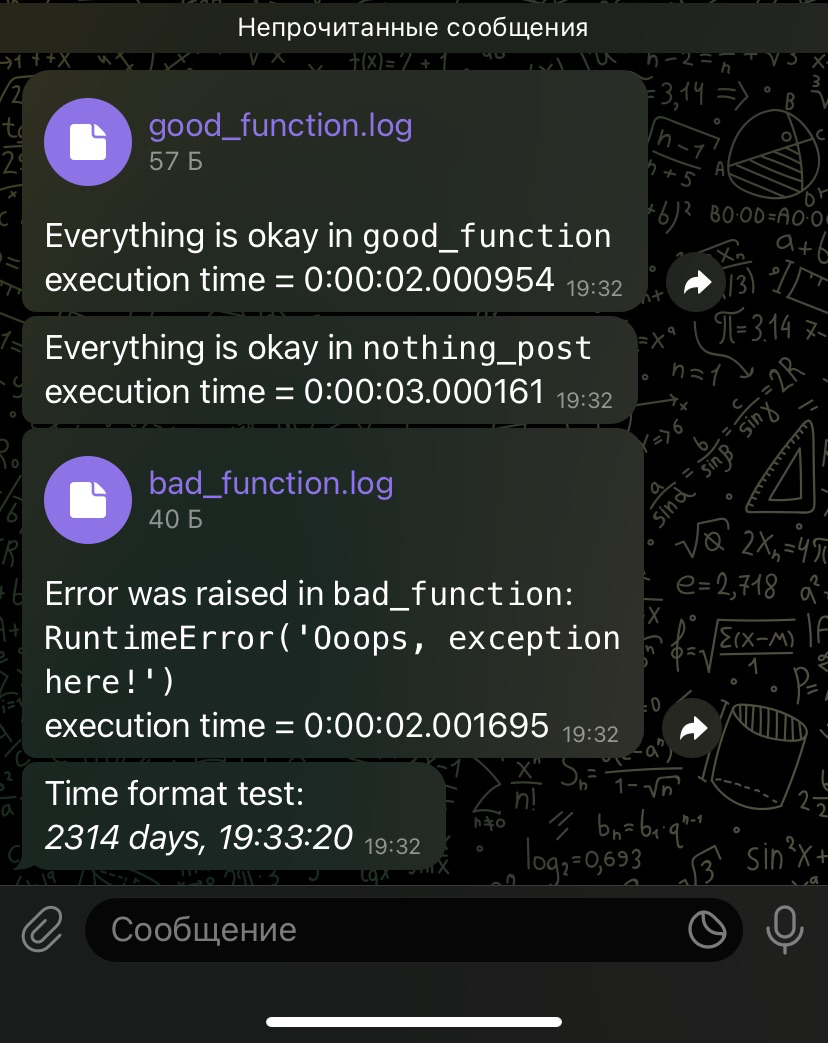  
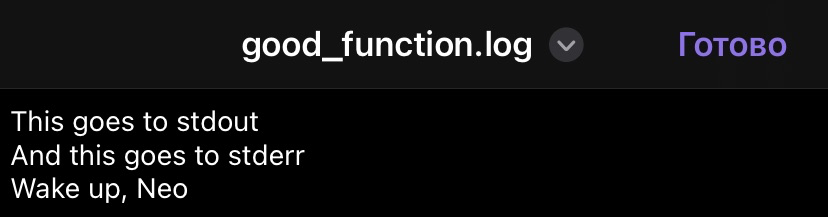  
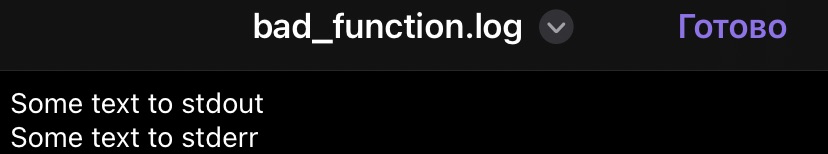

# Задание 3

В данном задании от вас потребуется сделать Python API для какого-либо сервиса

В задании предложено два варианта: простой и сложный, **выберите только один** из них.

Можно использовать только **модули стандартной библиотеки** и **requests**. Любые другие модули можно по согласованию с преподавателем.

❗❗❗ В **данном задании** требуется оформить код в виде отдельного модуля (как будто вы пишете свою библиотеку). Код в ноутбуке проверяться не будет ❗❗❗

## Вариант 1 (простой, 10 баллов)

В данном задании вам потребуется сделать Python API для сервиса http://hollywood.mit.edu/GENSCAN.html

Он способен находить и вырезать интроны в переданной нуклеотидной последовательности. Делает он это не очень хорошо, но это лучше, чем ничего. К тому же у него действительно нет публичного API.

Реализуйте следующую функцию:
`run_genscan(sequence=None, sequence_file=None, organism="Vertebrate", exon_cutoff=1.00, sequence_name="")` &mdash; выполняет запрос аналогичный заполнению формы на сайте. Принимает на вход все параметры, которые можно указать на сайте (кроме Print options). `sequence` &mdash; последовательность в виде строки или любого удобного вам типа данных, `sequence_file` &mdash; путь к файлу с последовательностью, который может быть загружен и использован вместо `sequence`. Функция должна будет возвращать объект типа `GenscanOutput`. Про него дальше.

Реализуйте **датакласс** `GenscanOutput`, у него должны быть следующие поля:
+ `status` &mdash; статус запроса
+ `cds_list` &mdash; список предсказанных белковых последовательностей с учётом сплайсинга (в самом конце результатов с сайта)
+ `intron_list` &mdash; список найденных интронов. Один интрон можно представить любым типом данных, но он должен хранить информацию о его порядковом номере, его начале и конце. Информацию о интронах можно получить из первой таблицы в результатах на сайте.
+ `exon_list` &mdash; всё аналогично интронам, но только с экзонами.

По желанию можно добавить любые данные, которые вы найдёте в результатах

# Look genescan_module directory